Proyecto 1 Inteligencia de Negocios
Grupo 6:

Apoyo al diagnóstico de pacientes: Identificación del problema del paciente a partir
de una descripción dada por el médico

Empezaremos importando todas las librerías necesarias para el proyecto.

In [77]:

import spacy
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NikCa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NikCa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Utilizaremos el siguiente método para poder obtener palabras únicas y poder contarlas en una lista de texto.

In [2]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count
    

Inicialmente realizaremos una exploración inicial para el análisis de la información.

In [3]:
clinical_text_df = pd.read_csv('medical_text_clasificacion.csv')

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['medical_abstracts', 'problems_described'], dtype='object')


,medical_abstracts,problems_described
0,Cell lineage markers in human pancreatic cance...,1
1,Fatal pulmonary venoocclusive disease secondar...,5
2,High survival rate in advanced-stage B-cell ly...,5
3,Intracranial chordoma in a preadolescent. Case...,1
4,Analysis of prognostic factors and clinicopath...,3


In [ ]:
Para facilitar la visualización de los datos y el proceso de clasificación, pondremos en forma de texto los problemas descritos.

In [8]:

clinical_text_df['problems_described'] = clinical_text_df['problems_described'].replace(to_replace =1,value ="Neoplasms")
clinical_text_df['problems_described'] = clinical_text_df['problems_described'].replace(to_replace =2,value ="Digestive system diseases")
clinical_text_df['problems_described'] = clinical_text_df['problems_described'].replace(to_replace =3,value ="Nervous system diseases")
clinical_text_df['problems_described'] = clinical_text_df['problems_described'].replace(to_replace =4,value ="Cardiovascular diseases")
clinical_text_df['problems_described'] = clinical_text_df['problems_described'].replace(to_replace =5,value ="General pathological conditions")
print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['medical_abstracts', 'problems_described'], dtype='object')


,medical_abstracts,problems_described
0,Cell lineage markers in human pancreatic cance...,Neoplasms
1,Fatal pulmonary venoocclusive disease secondar...,General pathological conditions
2,High survival rate in advanced-stage B-cell ly...,General pathological conditions
3,Intracranial chordoma in a preadolescent. Case...,Neoplasms
4,Analysis of prognostic factors and clinicopath...,Nervous system diseases


In [9]:

clinical_text_df = clinical_text_df[clinical_text_df['medical_abstracts'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['medical_abstracts'].tolist())
print("Número de oraciones en la columna de diagnósticos: "+ str(sent_count))
print("Número de palabras únicas en la columna de diagnósticos: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['problems_described'])
i = 1
print('===========Categorías =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')





Número de oraciones en la columna de diagnósticos: 101701
Número de palabras únicas en la columna de diagnósticos: 50782
===========Categorías =======================
Cat:1 Cardiovascular diseases : 2536
Cat:2 Digestive system diseases : 1242
Cat:3 General pathological conditions : 3993
Cat:4 Neoplasms : 2629
Cat:5 Nervous system diseases : 1600


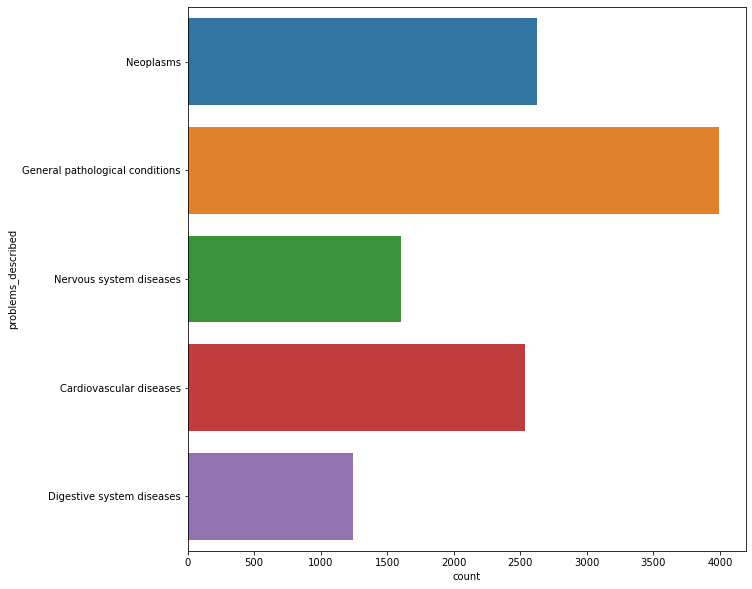

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(y='problems_described', data = filtered_data_categories )
plt.show()

In [12]:
data = filtered_data_categories[['medical_abstracts', 'problems_described']]
data = data.drop(data[data['medical_abstracts'].isna()].index)
data.shape


(12000, 2)

In [16]:
Ahora definiremos algunos métodos para limpiar la información

SyntaxError: invalid syntax (Temp/ipykernel_19752/4037184806.py, line 1)

In [17]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) 
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 


Limpiamos la información

In [18]:

data['medical_abstracts'] = data['medical_abstracts'].apply(lemmatize_text)
data['medical_abstracts'] = data['medical_abstracts'].apply(clean_text)

In [20]:
print('Muestra diagnóstico 1:'+data.iloc[5]['medical_abstracts']+'\n')
print('Muestra diagnóstico 2:'+data.iloc[125]['medical_abstracts']+'\n')
print('Muestra diagnóstico 3:'+data.iloc[1000]['medical_abstracts'])

Muestra diagnóstico 1:spinal accessory nerve palsy  an unusual complication of coronary artery bypass the neurologic complication of coronary artery bypass surgery have been well documented  with a reported incidence of   in one large study  prompt recognition of spinal accessory nerve damage after coronary bypass surgery is essential 

Muestra diagnóstico 2:causes of failure after repeat vitreoretinal surgery for recurrent proliferative vitreoretinopathy  with additional vitreoretinal procedure in six eye and after a mean followup period of  month   of  retina     were totally reattached  and an additional five eye     had retinal reattachment posterior to the scleral buckle 

Muestra diagnóstico 3:malignant potential of juvenile polyposis coli  at age   he underwent a proctectomy and a swenson pullthrough because of adenomatous change in the rectal stump 


Ahora utilizaremos la función TfidVectorizer para poder vectorizar las palabras y que de esta manera podamos introducir fácilmente la información a los modelos de clasificación. En este caso es importante tener en cuenta que se revisará las veces que se repite una palabra para conocer su importancia en el diagnóstico.

In [21]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['medical_abstracts'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abdominal', 'ability', 'abnormal', 'abnormality', 'abscess', 'absence', 'accuracy', 'achieved', 'acid', 'acquired', 'action', 'activation', 'active', 'activity', 'acute', 'acute myocardial', 'acute myocardial infarction', 'addition', 'additional', 'adenocarcinoma', 'adenoma', 'adhesion', 'adjuvant', 'administration', 'adult', 'advanced', 'adverse', 'affect', 'affected', 'age', 'agent', 'aggressive', 'aids', 'airway', 'alcohol', 'alpha', 'alteration', 'altered', 'analysis', 'anastomosis', 'andor', 'aneurysm', 'angina', 'angiographic', 'angiography', 'angioplasty', 'animal', 'antagonist', 'anterior', 'antibody', 'antigen', 'aorta', 'aortic', 'appear', 'appearance', 'appeared', 'appears', 'application', 'approach', 'appropriate', 'area', 'arrest', 'arrhythmia', 'arterial', 'artery', 'artery bypass', 'artery disease', 'arthroplasty', 'ascites', 'aspect', 'aspiration', 'assessment', 'associated', 'association', 'asymptomatic', 'atrial', 'atrial fibrillation', 'atrophy', 'author', 'availab

C:\Users\NikCa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Ahora veremos la distribución de las palabras encontradas 

C:\Users\NikCa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\NikCa\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


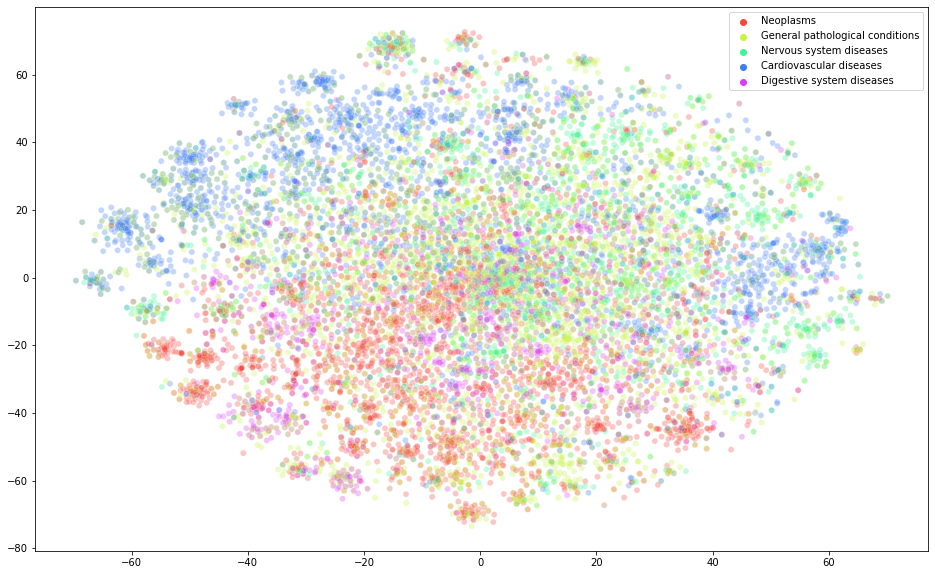

In [24]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['problems_described'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(5, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()



Ahora utilizaremos la técnica de Principal Component Analysis para reducir la dimensionalidad de las categorías. Esta técnica se define como una transformación lineal ortogonal que transforma la información a un nuevo sistema coordinado que facilita la comprensión para el modelo. 

In [27]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['problems_described'].tolist()
category_list = data.problems_described.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   


In [28]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(9000, 817)
Test_Set_Size:(3000, 817)


Ahora utilizaremos el algoritmo de regresión logística en el modelo para entrenarlo y que nos ayude eventualmente a predecir las categorías:

In [29]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Veremos la matriz de confusión y los resultados de clasificación:

In [40]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

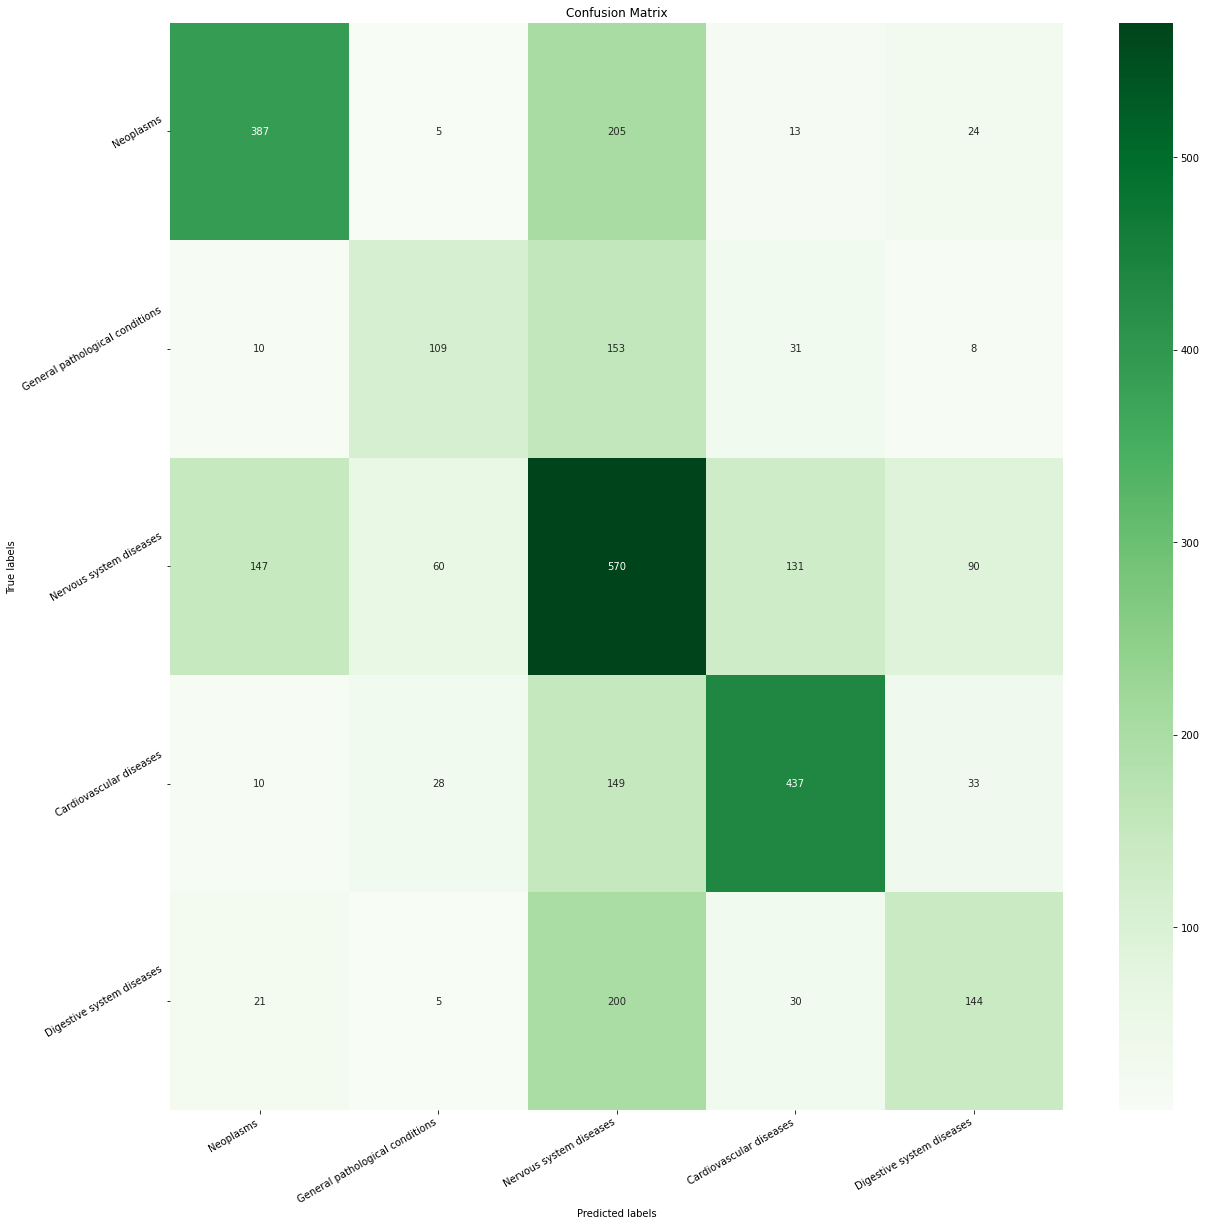

In [41]:

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [42]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                 precision    recall  f1-score   support

                      Neoplasms       0.68      0.67      0.67       657
General pathological conditions       0.45      0.57      0.50       998
        Nervous system diseases       0.48      0.36      0.41       400
        Cardiovascular diseases       0.67      0.61      0.64       634
      Digestive system diseases       0.53      0.35      0.42       311

                       accuracy                           0.55      3000
                      macro avg       0.56      0.51      0.53      3000
                   weighted avg       0.56      0.55      0.55      3000



Utilizaremos los modelos de sciscpacy para detectar palabras relacionadas con medicina en el texto.Estos modelos suelen utilizarse para procesar textos biomédicos, clínicos y científicos:

In [32]:

nlp = spacy.load("en_ner_bionlp13cg_md")

In [33]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)     

In [43]:
data['medical_abstracts'] = data['medical_abstracts'].apply(process_Text)
data['medical_abstracts'] = data['medical_abstracts'].apply(lemmatize_text)
data['medical_abstracts'] = data['medical_abstracts'].apply(clean_text)


In [52]:

print('Muestra 1:'+data.iloc[5]['transcription']+'\n')
print('Muestra 2:'+data.iloc[125]['transcription']+'\n')
print('Muestra 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:boyfriend bed her right facial right child bp name  cn only  motor rue pronator extremity flexor bilaterally  general cbc gs ua pt ptt esr crp ekg hct hypodensities right putamen left caudate subcortical right basal ganglion edema left caudate nucleus arterial fibromuscular dysplasia hiv ana anticardiolipin antibody cardiac enzyme b cholesterol cerebral vascular caliber her  right exam neck lymphadenopathy cervical biopsy cervix cervical cancer

Sample Transcription 2:performed   ureteral stent right renal pelvis urine right upper pole patient right kidney patient supine dorsal lithotomy ureter patient bladder patient prostate bladder patient bladder right ureteral orifice right ureteral right ureteral catheter bladder bladder proximal ureter upj ureteral dilating sheath amplatz sheath ureter upj ureter upj upj dilator right ureter upper papillary  biopsy forceps biopsy papillary mass bladder ureteral right renal right renal pelvis bladder bladder patient patient

In [53]:

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['medical_abstracts'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen abdomen', 'abdomen bowel', 'abdomen patient', 'abdominal', 'abdominal cavity', 'abdominal patient', 'abdominal wall', 'ace', 'acetabulum', 'achilles', 'achilles tendon', 'acid', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenopathy', 'adenosine', 'admission', 'adrenal', 'adrenal gland', 'airway', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'allergies', 'allograft', 'alt', 'amniotic', 'anesthesia', 'anesthesia patient', 'annular', 'anterior', 'anterior abdominal', 'anterior border', 'anterior border sternocleidomastoid', 'anterior cervical', 'anterior cruciate', 'anterolateral', 'antrum', 'aorta', 'aorta aorta', 'aortic', 'aortic arch', 'aortic valve', 'ap', 'ap lateral', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery carotid', 'artery carotid artery', 'artery coronary', 'artery coronary artery', 'artery left', 'artery patient', 'artery proximal', 'artery pulmonary', 'artery pulmonary artery', 'artery right', 'artery vessel',

C:\Users\NikCa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\NikCa\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


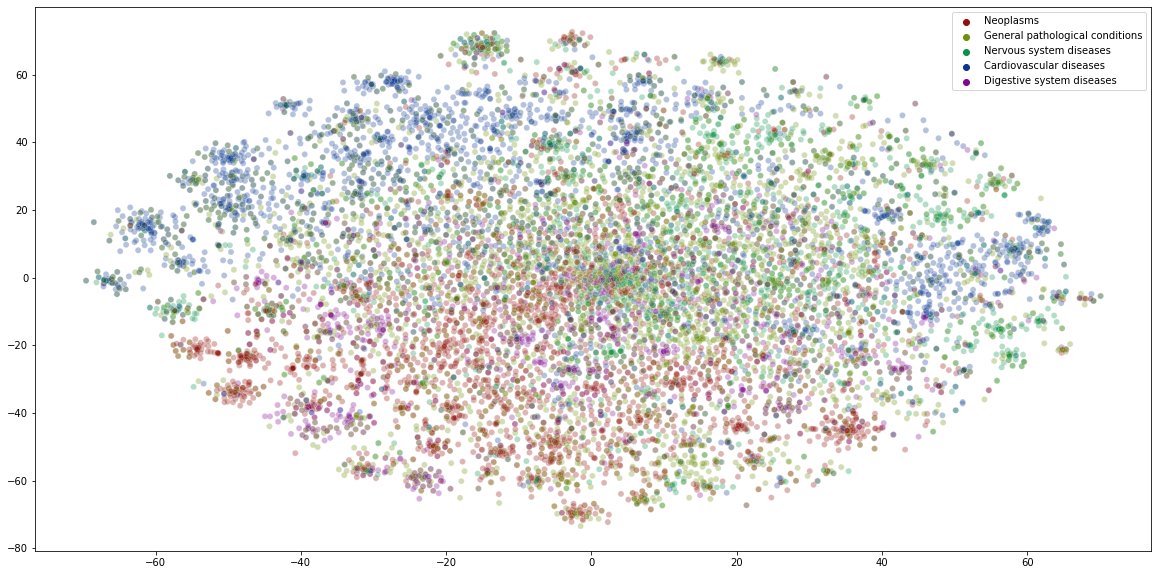

In [45]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['problems_described'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(5, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()



In [47]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['problems_described'].tolist()
category_list = data.problems_described.unique()

Volveremos a crear los conjuntos de prueba y entrenamiento para evaluar sus resultados a través del algoritmo de regresión logística:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(9000, 817)
Test_Set_Size:(3000, 817)


In [49]:

clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)


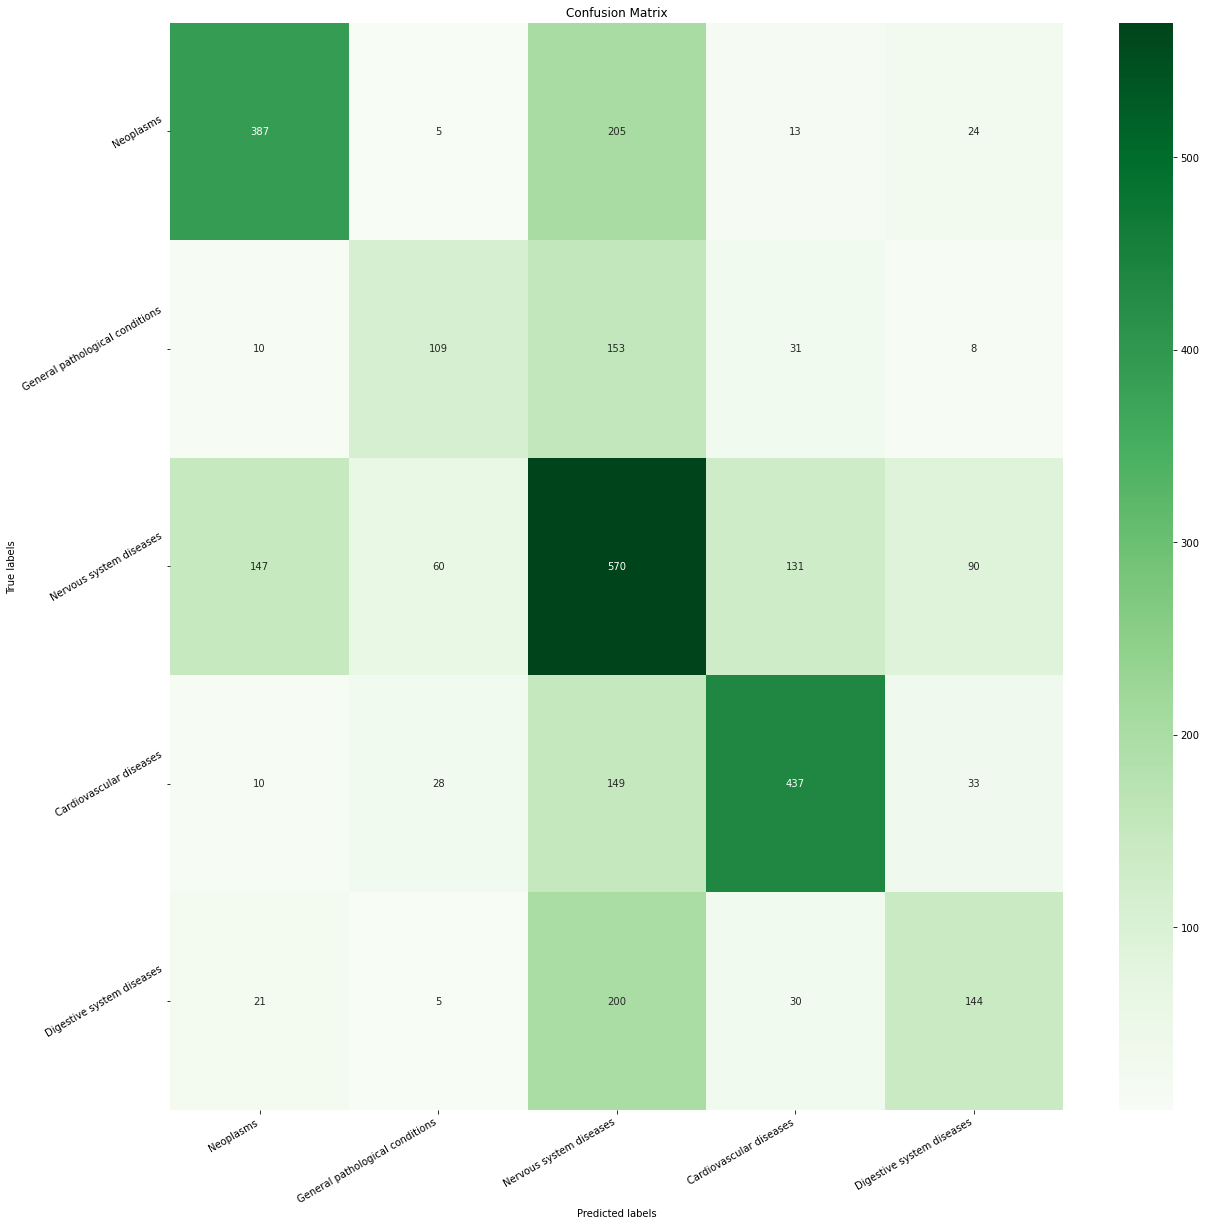

                                 precision    recall  f1-score   support

                      Neoplasms       0.68      0.67      0.67       657
General pathological conditions       0.45      0.57      0.50       998
        Nervous system diseases       0.48      0.36      0.41       400
        Cardiovascular diseases       0.67      0.61      0.64       634
      Digestive system diseases       0.53      0.35      0.42       311

                       accuracy                           0.55      3000
                      macro avg       0.56      0.51      0.53      3000
                   weighted avg       0.56      0.55      0.55      3000



In [51]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))


Como algunas clases son minoritarias, utilizaremos SMOTE para evitar problemas de OVER y SUB Sampling:


In [52]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['problems_described'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(11063, 817)
Test_Set_Size:(3688, 817)


In [53]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Ahora visualizaremos cómo queda la información

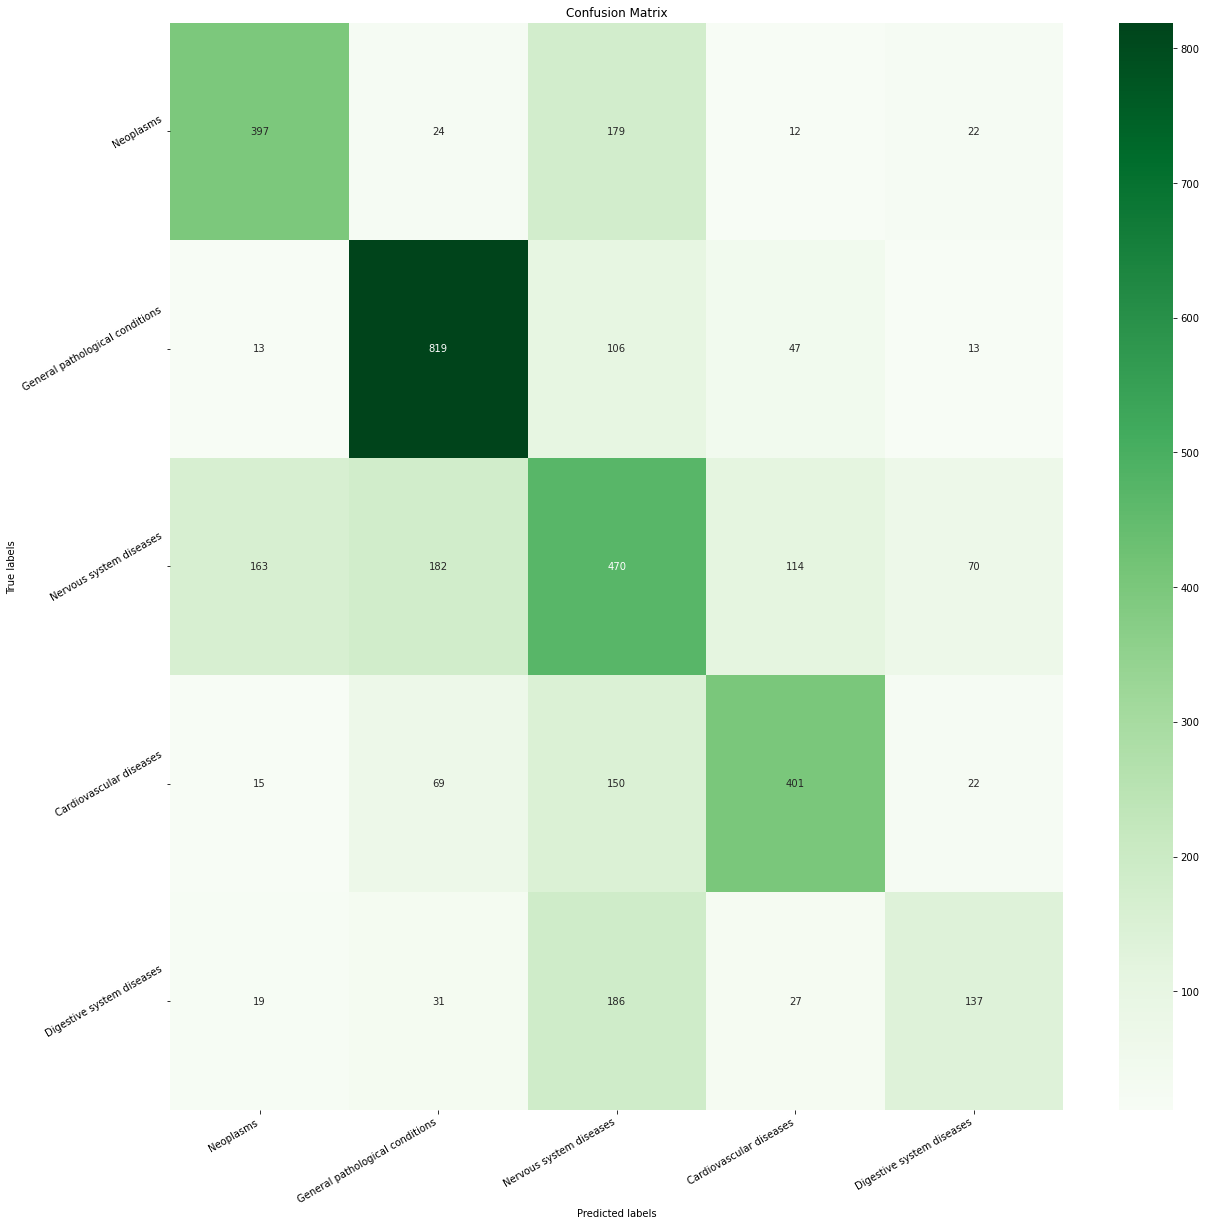

                                 precision    recall  f1-score   support

                      Neoplasms       0.67      0.61      0.64       657
General pathological conditions       0.43      0.47      0.45       999
        Nervous system diseases       0.52      0.34      0.41       400
        Cardiovascular diseases       0.65      0.63      0.64       634
      Digestive system diseases       0.73      0.82      0.77       998

                       accuracy                           0.60      3688
                      macro avg       0.60      0.57      0.58      3688
                   weighted avg       0.60      0.60      0.60      3688



In [54]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

Podemos observar que algunos puntajes mejoran, por lo que concluimos que la técnica fue efectiva. 

Ahora utilizaremos el algoritmo de Multi-layer Perceptron classifier para observar la variación en los resultados y poder escoger el mejor modelo:

In [83]:
clf2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_test_pred= clf2.predict(X_test)

Visualizamos los resultados

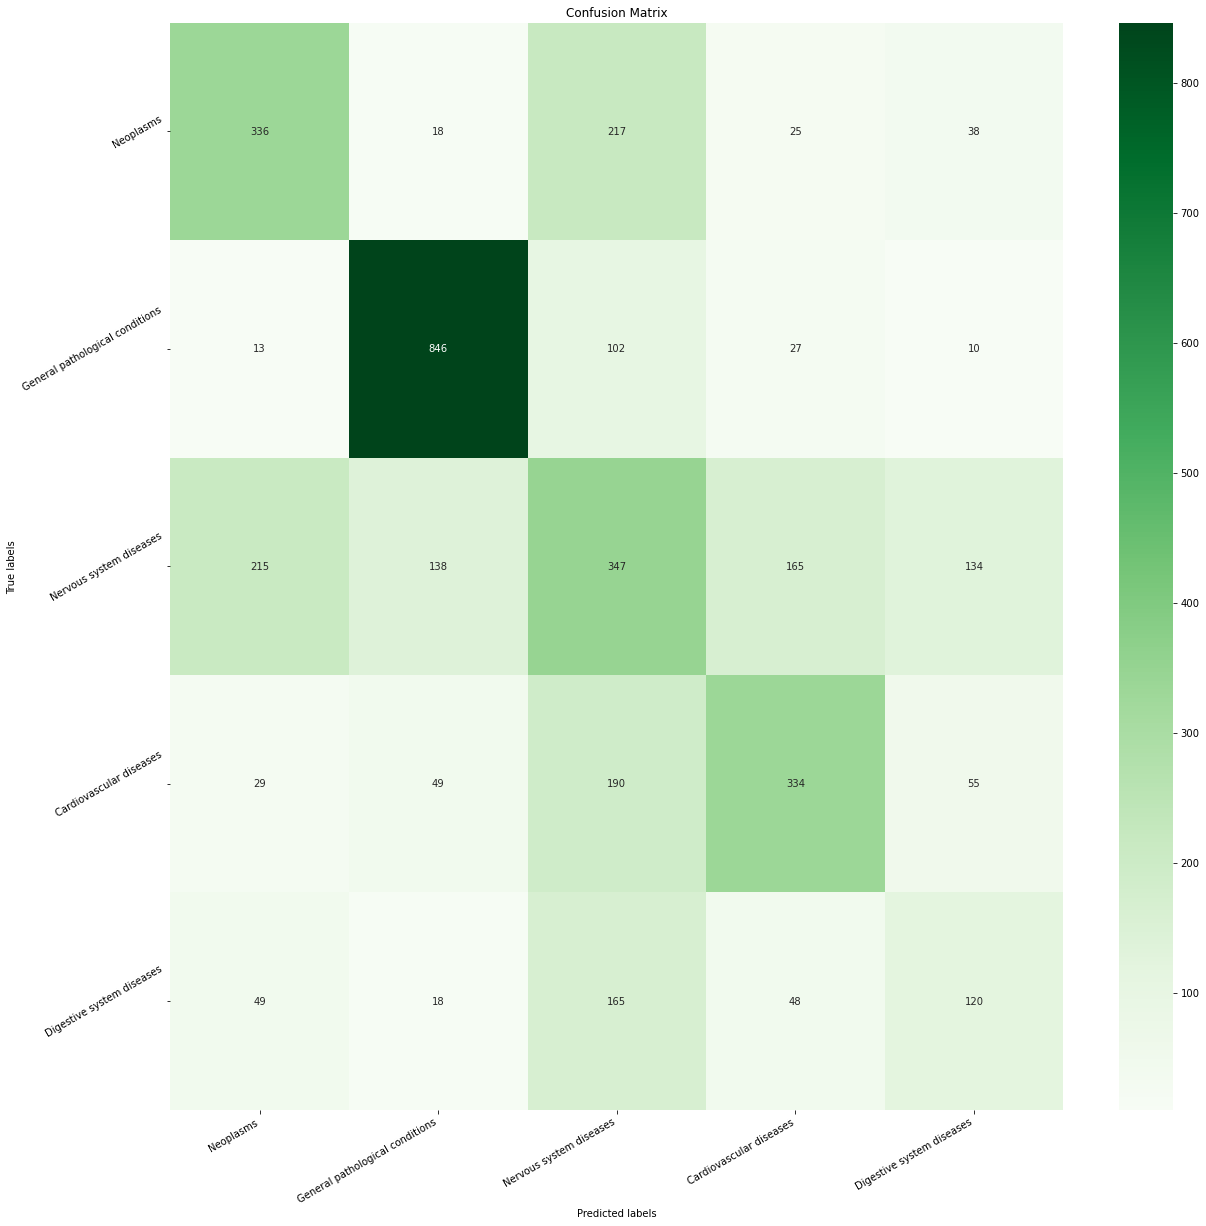

                                 precision    recall  f1-score   support

                      Neoplasms       0.56      0.51      0.53       657
General pathological conditions       0.34      0.35      0.34       999
        Nervous system diseases       0.34      0.30      0.32       400
        Cardiovascular diseases       0.52      0.53      0.53       634
      Digestive system diseases       0.79      0.85      0.82       998

                       accuracy                           0.54      3688
                      macro avg       0.51      0.51      0.51      3688
                   weighted avg       0.53      0.54      0.53      3688



In [84]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

Evidenciamos que el f1-score, la precisión y el recall son mucho mejores para clasificar enfermedades del sistema digestivo en este modelo, sin embargo, lamentablemente los resultados en general no son mejores que los previamente obtenidos.

Por último, utilizaremos el algoritmo de árboles de decisión para compararlo con los dos anteriores

In [85]:

clf3 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None,max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, random_state=None, splitter='best').fit(X_train, y_train)
y_test_pred= clf3.predict(X_test)

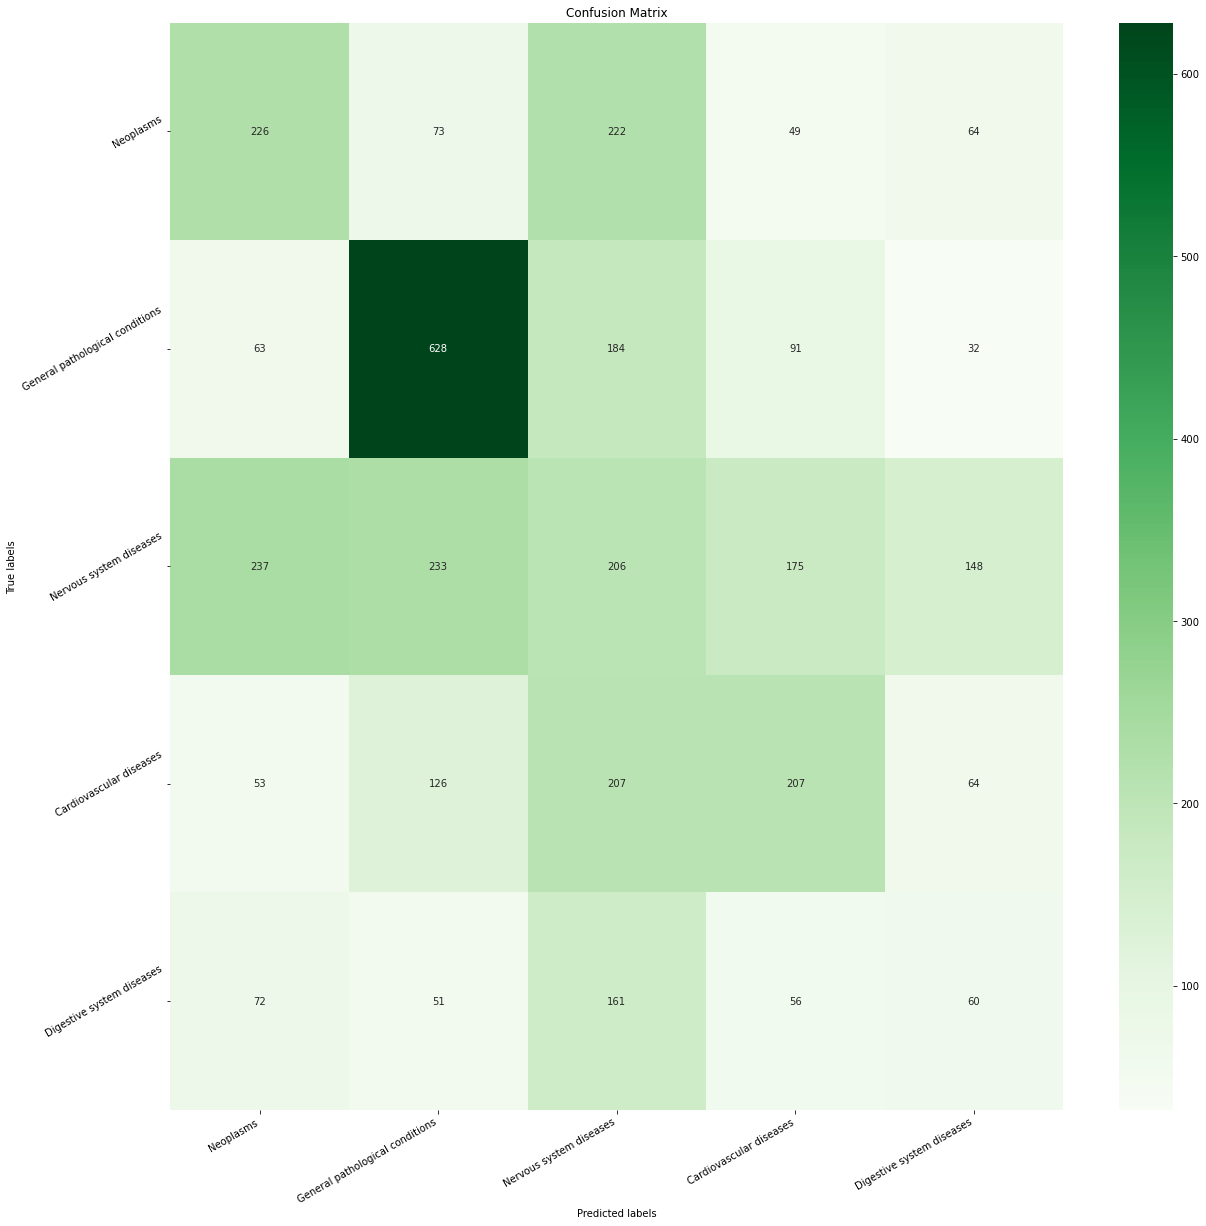

                                 precision    recall  f1-score   support

                      Neoplasms       0.36      0.32      0.34       657
General pathological conditions       0.21      0.21      0.21       999
        Nervous system diseases       0.16      0.15      0.16       400
        Cardiovascular diseases       0.35      0.36      0.35       634
      Digestive system diseases       0.57      0.63      0.60       998

                       accuracy                           0.36      3688
                      macro avg       0.33      0.33      0.33      3688
                   weighted avg       0.35      0.36      0.35      3688



In [86]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

In [ ]:
Como podemos observar, la técnica de árboles de decisión nos arroja los peores resultados en general en comparación con los otros modelos, por lo tanto, no se recomienda en lo absoluto hacer uso de ella.